<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [1]:
#import os
#import tensorflow as tf
#import numpy as np
#import random as rn

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#np.random.seed(37)
#tf.random.set_seed(89)

#import numpy as np
#import os
#import random
#import tensorflow as tf # 2.2.0

#SEED = 42
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
#np.random.seed(SEED)
#random.seed(SEED)
#tf.random.set_seed(SEED)

In [18]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PROCESSING

In [20]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [21]:
img_width, img_height = 224, 224 
nb_train_samples = 560
nb_validation_samples = 140
epochs = 100
batch_size = 16

In [22]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [7]:
#Experimental block of code for hsv - has issues with range (0-255) which will not produce efficient training
#import cv2
#import numpy as np
#from PIL import Image
#def myFunc(image):
 #   image = np.array(image)
  #  hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
   # hsv_image = hsv_image.astype('float32')
    #hsv_image = hsv_image / 255.0
    #return Image.fromarray(hsv_image)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


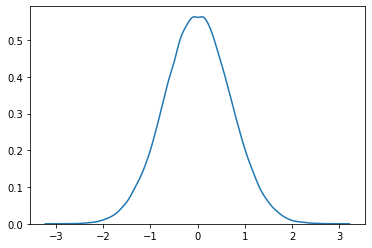

In [8]:
import seaborn as sns

sns.distplot(np.random.normal(0.0, 0.7, size=(224,224,3)), hist=False)

plt.show()

In [23]:
# Inspired by random crop functionality from https://jkjung-avt.github.io/keras-image-cropping/
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        #noise_factor = 0.1
        noise = np.random.normal(0.0, scale=sigma, size=batch_x.shape)
        #noise = np.random.normal(0, 0.1, batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [24]:
#Performing augmentation on image scaling, zoom and flipping so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2,
	brightness_range=(0.6,0.9) #Range starts from 0.6 so that the images dont become too dark for the model to recognize
	) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

#Adding noise
train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [25]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

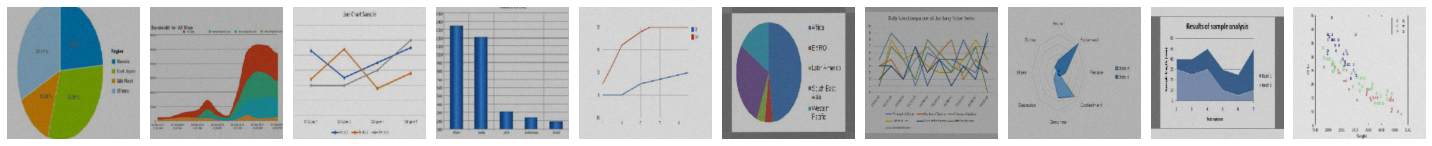

In [28]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:10])

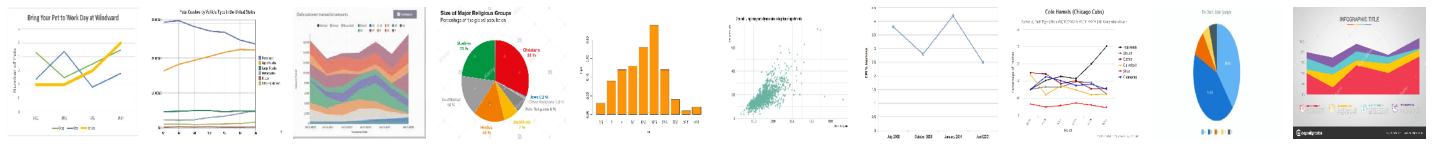

In [29]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

#BASELINE CNN MODEL

In [30]:
# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


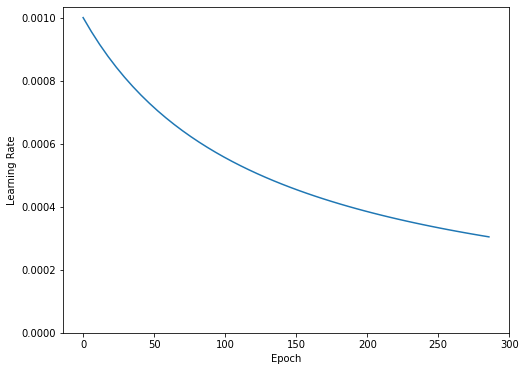

In [31]:
STEPS_PER_EPOCH = nb_train_samples // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=8,
  staircase=False)

step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [32]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [33]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history = model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 16s 467ms/step - loss: 2.8085 - accuracy: 0.2643 - val_loss: 1.6579 - val_accuracy: 0.3359
Epoch 2/100
35/35 [==============================] - 16s 456ms/step - loss: 1.4594 - accuracy: 0.4214 - val_loss: 1.3842 - val_accuracy: 0.4844
Epoch 3/100
35/35 [==============================] - 16s 463ms/step - loss: 1.3597 - accuracy: 0.4643 - val_loss: 1.6370 - val_accuracy: 0.4141
Epoch 4/100
35/35 [==============================] - 16s 465ms/step - loss: 1.2253 - accuracy: 0.5143 - val_loss: 1.3969 - val_accuracy: 0.4453
Epoch 5/100
35/35 [==============================] - 16s 457ms/step - loss: 1.1633 - accuracy: 0.5411 - val_loss: 1.4011 - val_accuracy: 0.5391
Epoch 6/100
35/35 [==============================] - 16s 457ms/step - loss: 0.9728 - accuracy: 0.5696 - val_loss: 1.6143 - val_accuracy: 0.5625
Epoch 7/100
35/35 [==============================] - 16s 455ms/step - loss: 0.8683 - accuracy: 0.6339 - val_loss: 1.4612 - val_accuracy:

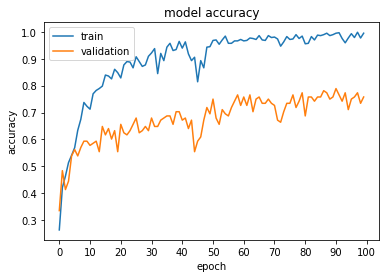

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

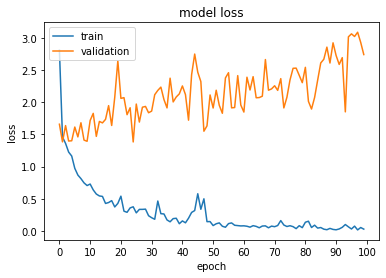

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#ABLATION STUDY

# <H4>Remove data augementation, gaussian noise and learning rate scheduling - keep all classes

In [36]:
train_datagen_2 = ImageDataGenerator(rescale=1. /255)
val_datagen_2 = ImageDataGenerator(rescale=1. / 255) 

train_generator_2 = train_datagen_2.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator_2 = val_datagen_2.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


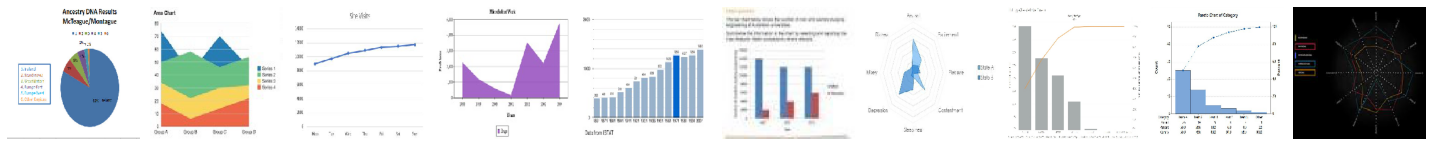

In [37]:
sample_training_images, _ = next(train_generator_2)
plotImages(sample_training_images[:10])

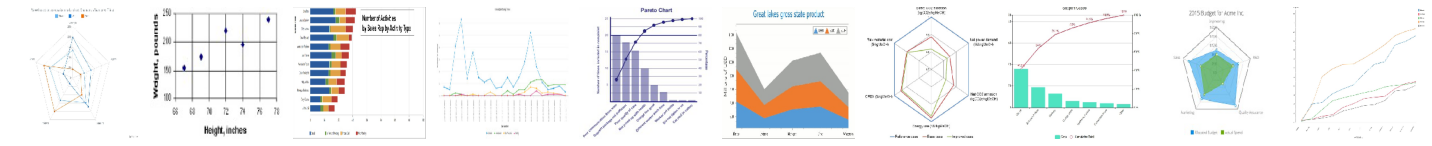

In [38]:
sample_training_images, _ = next(validation_generator_2)
plotImages(sample_training_images[:10])

In [39]:
model_repeat = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [40]:
lr=0.001
model_repeat.compile(optimizer=keras.optimizers.Adam(lr) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [41]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history2 = model_repeat.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 6s 168ms/step - loss: 2.1067 - accuracy: 0.3589 - val_loss: 1.5005 - val_accuracy: 0.4922
Epoch 2/100
35/35 [==============================] - 6s 163ms/step - loss: 0.8649 - accuracy: 0.6768 - val_loss: 1.1978 - val_accuracy: 0.6719
Epoch 3/100
35/35 [==============================] - 6s 159ms/step - loss: 0.5540 - accuracy: 0.8125 - val_loss: 1.0996 - val_accuracy: 0.7031
Epoch 4/100
35/35 [==============================] - 6s 159ms/step - loss: 0.3173 - accuracy: 0.9000 - val_loss: 1.1894 - val_accuracy: 0.6406
Epoch 5/100
35/35 [==============================] - 6s 163ms/step - loss: 0.2015 - accuracy: 0.9429 - val_loss: 1.0904 - val_accuracy: 0.7188
Epoch 6/100
35/35 [==============================] - 6s 161ms/step - loss: 0.0885 - accuracy: 0.9714 - val_loss: 1.5797 - val_accuracy: 0.7109
Epoch 7/100
35/35 [==============================] - 6s 162ms/step - loss: 0.0231 - accuracy: 0.9982 - val_loss: 1.4483 - val_accuracy: 0.7500

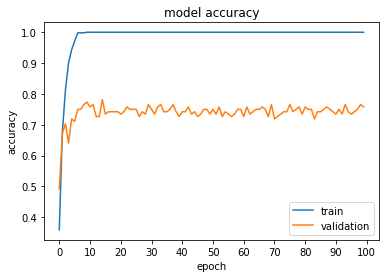

In [42]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

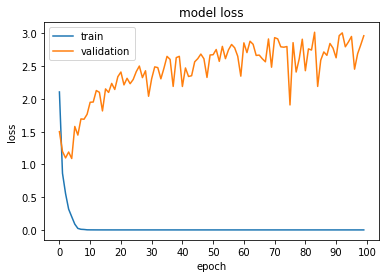

In [43]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# <H4> Remove gaussian noise and learning rate - keep data augmentation and all classes

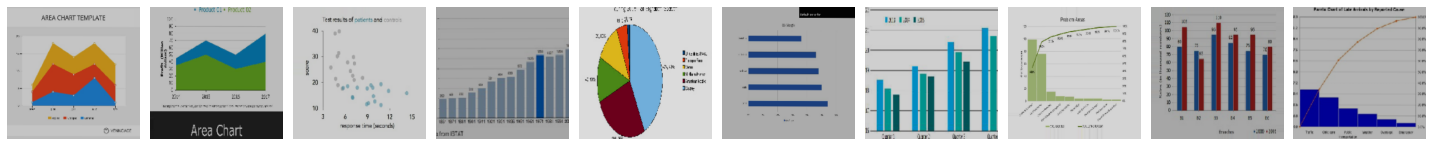

In [44]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:10])

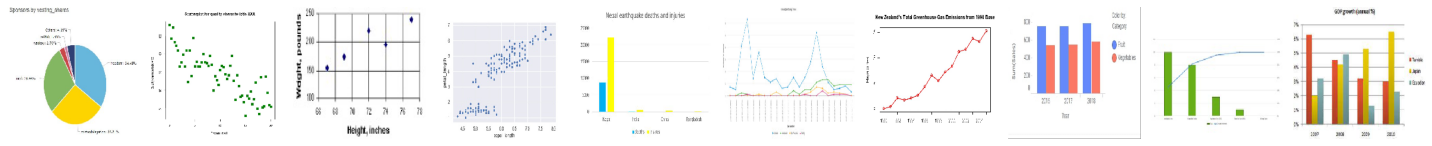

In [45]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

In [46]:
model_repeat_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [47]:
lr=0.001
model_repeat_3.compile(optimizer=keras.optimizers.Adam(lr) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)            

In [48]:
history3 = model_repeat_3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 12s 341ms/step - loss: 2.1542 - accuracy: 0.2571 - val_loss: 1.5786 - val_accuracy: 0.4062
Epoch 2/100
35/35 [==============================] - 12s 336ms/step - loss: 1.1507 - accuracy: 0.5714 - val_loss: 1.0245 - val_accuracy: 0.6172
Epoch 3/100
35/35 [==============================] - 12s 340ms/step - loss: 0.8021 - accuracy: 0.6982 - val_loss: 1.0322 - val_accuracy: 0.6953
Epoch 4/100
35/35 [==============================] - 12s 343ms/step - loss: 0.6236 - accuracy: 0.7750 - val_loss: 1.0502 - val_accuracy: 0.6719
Epoch 5/100
35/35 [==============================] - 12s 340ms/step - loss: 0.4762 - accuracy: 0.8196 - val_loss: 1.3177 - val_accuracy: 0.6797
Epoch 6/100
35/35 [==============================] - 12s 338ms/step - loss: 0.4618 - accuracy: 0.8339 - val_loss: 0.8113 - val_accuracy: 0.7734
Epoch 7/100
35/35 [==============================] - 12s 340ms/step - loss: 0.3518 - accuracy: 0.8732 - val_loss: 1.1505 - val_accuracy:

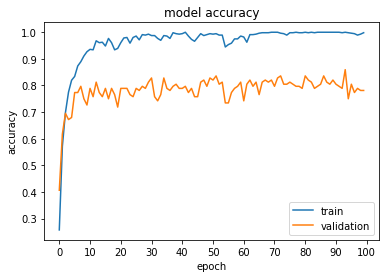

In [49]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

#<H4>Remove gaussian noise - keep learning rate scheduling, data augmentation and all classes

In [50]:
model_repeat_4 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [51]:
model_repeat_4.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)            

In [52]:
history4 = model_repeat_4.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
35/35 [==============================] - 12s 345ms/step - loss: 2.3037 - accuracy: 0.2500 - val_loss: 1.5100 - val_accuracy: 0.4375
Epoch 2/100
35/35 [==============================] - 12s 344ms/step - loss: 1.2298 - accuracy: 0.5643 - val_loss: 1.3041 - val_accuracy: 0.5078
Epoch 3/100
35/35 [==============================] - 12s 341ms/step - loss: 0.8735 - accuracy: 0.6893 - val_loss: 1.0782 - val_accuracy: 0.6797
Epoch 4/100
35/35 [==============================] - 12s 340ms/step - loss: 0.6499 - accuracy: 0.7696 - val_loss: 1.2899 - val_accuracy: 0.6406
Epoch 5/100
35/35 [==============================] - 12s 345ms/step - loss: 0.6015 - accuracy: 0.7804 - val_loss: 1.1840 - val_accuracy: 0.6562
Epoch 6/100
35/35 [==============================] - 12s 341ms/step - loss: 0.5116 - accuracy: 0.8089 - val_loss: 1.3122 - val_accuracy: 0.6641
Epoch 7/100
35/35 [==============================] - 12s 342ms/step - loss: 0.4105 - accuracy: 0.8571 - val_loss: 1.1654 - val_accuracy:

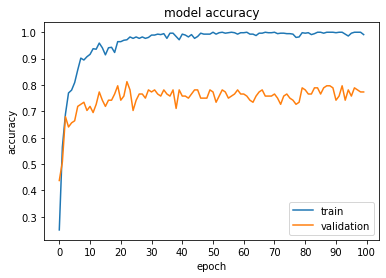

In [53]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

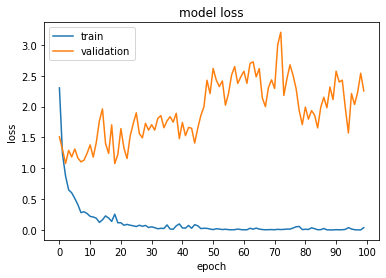

In [54]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#<H4>Keep gaussian noise, learning rate scheduling & data aug - remove pareto chart and radar chart classes (only 5 charts)

In [55]:
train_generator_5 = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical',
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"]) 

validation_generator_5 = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
  classes=["AreaChart", "BarChart", "LineChart", "PieChart", "ScatterPlot"])

#Adding noise
train_noisy_5 = noisy_generator(train_generator_5)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [56]:
model_repeat_5 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])

In [57]:
model_repeat_5.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_repeat_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50176)            

In [58]:
train_samples = 400
val_samples = 100

In [59]:
history5 = model_repeat_5.fit( 
	train_noisy_5, 
	steps_per_epoch=train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator_5, 
	validation_steps= val_samples // batch_size)

Epoch 1/100
25/25 [==============================] - 12s 472ms/step - loss: 2.5178 - accuracy: 0.2800 - val_loss: 1.3733 - val_accuracy: 0.5625
Epoch 2/100
25/25 [==============================] - 11s 459ms/step - loss: 1.2516 - accuracy: 0.4725 - val_loss: 1.3115 - val_accuracy: 0.5104
Epoch 3/100
25/25 [==============================] - 11s 459ms/step - loss: 1.1037 - accuracy: 0.5450 - val_loss: 1.1679 - val_accuracy: 0.5625
Epoch 4/100
25/25 [==============================] - 11s 454ms/step - loss: 0.9096 - accuracy: 0.5825 - val_loss: 1.1548 - val_accuracy: 0.5625
Epoch 5/100
25/25 [==============================] - 11s 458ms/step - loss: 0.7218 - accuracy: 0.6750 - val_loss: 1.1733 - val_accuracy: 0.5729
Epoch 6/100
25/25 [==============================] - 11s 458ms/step - loss: 0.6588 - accuracy: 0.6625 - val_loss: 1.0111 - val_accuracy: 0.6562
Epoch 7/100
25/25 [==============================] - 12s 461ms/step - loss: 0.6059 - accuracy: 0.7125 - val_loss: 1.2170 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()